# **Time Series With LSTM**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [ ]:
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


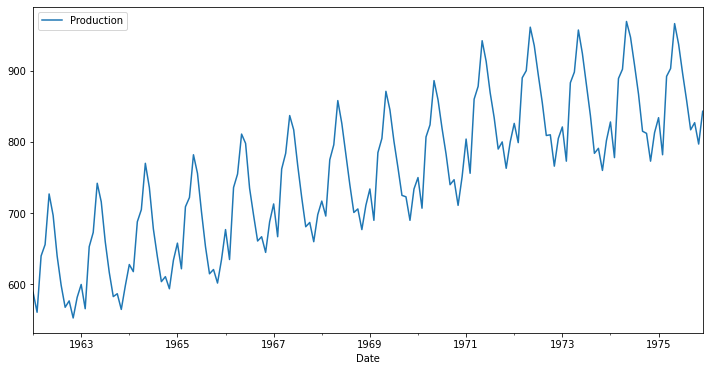

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

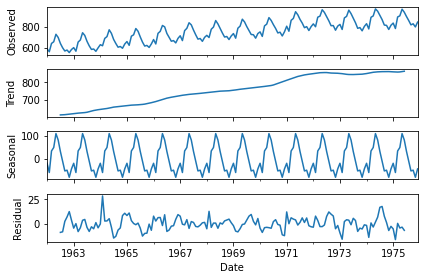

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot();

In [ ]:
len(df)

168

In [ ]:
168-12

156

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
123 4 --> 345 --> 456 --> 567 --> 567 

In [ ]:
# define generator
n_input = 3 #picking 3 bacthes at a time to predict the next batch
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X,y = generator[2]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.20913462 0.24759615 0.41826923]
Predict this y: 
 [[0.34615385]]


In [ ]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 6ms/step - loss: 0.0488
Epoch 2/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0217
Epoch 3/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0189
Epoch 4/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0161
Epoch 5/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0158
Epoch 6/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0085
Epoch 7/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0062
Epoch 8/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0069
Epoch 9/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0045
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0046
Epoch 11/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0039
Epoch 12/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0035
Epoch 13/50
144/144 [====

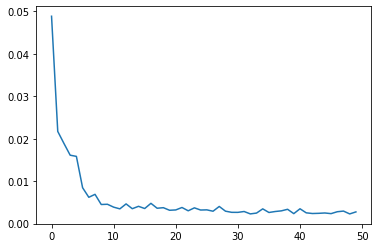

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

#Make Predictions with LSTM

In [ ]:
last_train_batch = scaled_train[-12:] #Using the last 12 months data

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

array([[0.6046266]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.67548077])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-12:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

[array([0.6046266], dtype=float32),
 array([0.59602916], dtype=float32),
 array([0.76950246], dtype=float32),
 array([0.8569678], dtype=float32),
 array([0.9477659], dtype=float32),
 array([0.9341034], dtype=float32),
 array([0.8713361], dtype=float32),
 array([0.7691886], dtype=float32),
 array([0.65411985], dtype=float32),
 array([0.6026539], dtype=float32),
 array([0.55033773], dtype=float32),
 array([0.5841952], dtype=float32)]

In [ ]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test.tail()

,Production,Predictions
Date,,
1975-08-01,858,872.982450
1975-09-01,817,825.113857
1975-10-01,827,803.704031
1975-11-01,797,781.940496
1975-12-01,843,796.025202


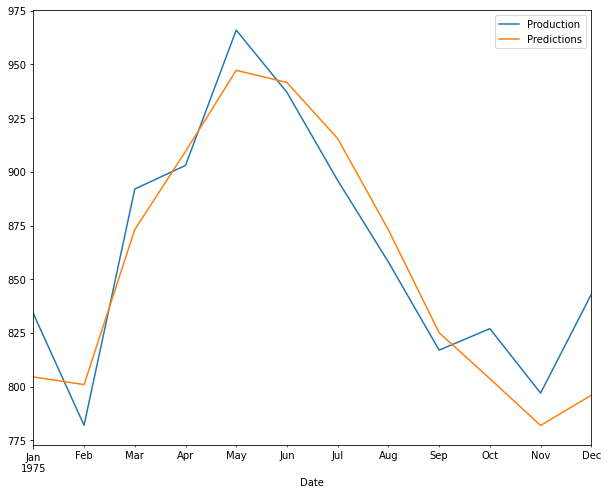

In [ ]:
test.plot(figsize=(10,8))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

21.687835112554595
